In [8]:
#---------------------------------------------------
#---------------------IMPORTS-----------------------
#---------------------------------------------------
import numpy as np #for matrix manipulation
import pandas as pd #for reading CSV
import matplotlib.pyplot as plt #for graphing

#---------------------------------------------------

#---------------------------------------------------
#datasets are located in google drive 
#below code establish access to drive
from google.colab import drive
drive.mount('/content/drive')
#---------------------------------------------------



#------------------------------------------------------------------
#---------------------LOAD DATASETS--------------------------------
#------------------------------------------------------------------

#---------------------------------------------------
#function name: load_dataset
#purpose : using pandas lib to include CSV dataset files
#parameters:None
#output : 
#       4 numpy arrays as follows 
#                     (x_train,y_train,x_test,y_test)
#----------------------------------------------------

def load_dataset():

  x_train = pd.read_csv('drive/My Drive/trainData.csv',sep=',')
  y_train = pd.read_csv('trainLabels.csv')
  x_test = pd.read_csv('drive/My Drive/testData.csv',sep=',')
  y_test = pd.read_csv('testLabels.csv')

  #convert pandas dataframes to numpy arrays
  x_train = x_train.to_numpy()
  y_train = y_train.to_numpy()
  x_test = x_test.to_numpy()
  y_test = y_test.to_numpy()

  return x_train,y_train,x_test,y_test

#----------------------------------------------------------------------


#------------------------------------------------------------------
#---------------------DATA PREPARATION-----------------------------
#------------------------------------------------------------------

#---------------------------------------------------
#function name: prepare_dataset
#purpose : normalize dataset to [0,1], z-score transformation
#parameters:
#           dataset: the dataset to be prepared
#output : None
#----------------------------------------------------

def prepare_dataset(dataset):

  n_features = dataset.shape[1]

  #normalizing----------------------------
  dataset = dataset.astype('double') / 255
  #---------------------------------------

  #z-score transformation-----------------
  mean = dataset.mean(axis=0).reshape(1,n_features)
  var = x_train.var(axis=0).reshape(1,n_features)
  dataset = np.subtract(x_train,mean)

  #NOTE: variance was too small, so 
  #      dividing samples by their variance produce large numbers
  #      which may cause instablity in computation

  #x_train = np.divide(x_train,var)
  #x_test = np.divide(x_test,var)
  #----------------------------------------

#-----------------------------------------------------------------


#------------------------------------------------------------------
#---------------------PCA FEATURE SELECTION------------------------
#------------------------------------------------------------------

#---------------------------------------------------
#function name: pca_feature_selection
#purpose : to reduce the dimensionality of inputs
#parameters:
#           x_train,x_test : 
#           n_selected_f : number of features(aka eigen vectors) to be selected
#output : 
#       W : vector of eigen values 
#       top :transformation matrix(each column corresponds to a selected eivector)
#       #x_train_trans,x_test_trans : trasformed datasets
#----------------------------------------------------


def pca_feature_selection(x_train,x_test,n_selected_f):
  
  n_features = x_train.shape[1]
  n_samples = x_train.shape[0]
  #---------------COMPUTING SCATTER MATRIX---------------------
  scatter_matrix = np.zeros((n_features,n_features));
  for i in range(0,n_samples):
    temp = np.matmul(x_train[i,:].reshape(n_features,1),x_train[i,:].reshape(1,n_features))
    scatter_matrix += temp
  #-------------------------------------------------------------

  #finding eigen values and eigen vectors
  W,V = np.linalg.eig(scatter_matrix)
 
  #reaarange indices of elements of W based on values of the elements ascendingly!
  indices = np.argsort(W)
  #reverse the elements of indices (we need them in descending order)
  indices = indices[::-1]

  top = V[:,indices[0:n_selected_f]] #select top n_selected_f vectors of V

  #apply transformation on x_train and x_test
  x_train_trans = np.matmul(x_train,top)
  x_test_trans = np.matmul(x_test,top)
  #------------------------------------------

  return W,top,x_train_trans,x_test_trans

  #-------------------------------------------------------------------



In [9]:
#------------------------------------------------------------------
#---------------------Compute STATISTICS---------------------------
#------------------------------------------------------------------

#---------------------------------------------------
#function name: compute_stats
#purpose : computing frequency of occurance,priori,mean and covariance
#          for each class
#          
#parameters:
#           x_train,y_train
#           n_class: number of classes
#output : 
#       freqs,priories,means,covs
#----------------------------------------------------
def compute_stats(x_train,y_train,n_class):

  n_samples = x_train.shape[0]
  n_features = x_train.shape[1]

  #define placeholders----------------
  priories = np.zeros([n_class,1])
  freqs = np.zeros([n_class,1])
  means = np.zeros([n_class,n_features])
  covs = np.zeros([n_features,n_features,n_class]);
  #-----------------------------------
  
  #computing frequencies,means and priories
  for i in range(n_samples):
    c = y_train[i][0]
    freqs[c]+=1
    means[c,:] += x_train[i,:]
  priories = freqs / n_samples;

  for i in range(n_class):
    means[i,:] /= freqs[i]
  #------------------------------------

  #computing covariances---------------
  for i in range(n_samples):
    c = y_train[i,0]
    x_i = x_train[i,:]
    covs[:,:,c] += np.matmul((x_i - means[c,:]).reshape((n_features,1)), (x_i - means[c,:]).reshape((1,n_features)))

  for i in range(10):
    covs[:,:,i] /= (freqs[i]-1)
  #-------------------------------------

  return freqs,priories,means,covs

#----------------------------------------------------------------------



In [10]:
#------------------------------------------------------------------
#---------------------DISCRIMINATOR--------------------------------
#------------------------------------------------------------------

#---------------------------------------------------
#function name: compute_disc_params
#purpose : computes coefficeints of quadratic discriminator for gaussian distro
#         
#parameters:
#          priories : vectors consists of prior probabilities of classes(dim:n_classes * 1 )
#          means: a matrix consists of means of classes(dim: n_classes * n_features)
#          covs: an array of #(n_classes) matrices each represents the covariance matrix of a class 
#output : 
#       W_i,w_i,w_i0
#----------------------------------------------------
def disc_params(priories,means,covs):
  n_selected_f = covs.shape[0]

  #define placeholders
  W_is = np.zeros([n_selected_f,n_selected_f,10])
  w_is = np.zeros([10,n_selected_f])
  w_i0 = np.zeros([10,1])
  #---------------------------------------------

  cov_inv = np.zeros([n_selected_f,n_selected_f,10])
  covs = covs.astype('double')

  for i in range(10):
    cov_inv[:,:,i] = np.linalg.inv(covs[:,:,i])

  
  W_is = (-1/2)*cov_inv
  cov_inv = cov_inv.astype('double')
  for i in range(10):
    w_is[i,:] = np.matmul(cov_inv[:,:,i],(means[i,:]).reshape((n_selected_f,1))).reshape((n_selected_f))
    w_i0[i,0] = (-1/2)*np.dot((means[i,:]).reshape((1,n_selected_f)),(w_is[i,:]).reshape((n_selected_f,1)))[0,0] -(1/2)*np.log(np.linalg.det(covs[:,:,i]))  + np.log(priories[i,0])
  
  return W_is,w_is,w_i0
#-------------------------------------------------------------------

#------------------------------------------------------------------
#---------------------COVARIANCE SINGULARITY-----------------------
#------------------------------------------------------------------

#---------------------------------------------------
#function name: max_ent_cov_estimator
#purpose : addressing covariance matrix singularity using maximum entropy estimation
#         
#parameters:
#          covs :an array of covaraines matrices
#output : 
#       mecs : an array of transformed covariances that is non-singular!
#----------------------------------------------------

def max_ent_cov_estimator(covs):

  n_classes = 10

  #covariance pool : sum of all covariance matrices
  cov_p =  np.zeros((covs.shape[0],covs.shape[0]))

  for i in range(1,n_classes):
    cov_p += covs[:,:,i]

  cov_p /= n_classes;
  #-------------------------------------------------
  
  mecs = np.zeros((covs.shape[0],covs.shape[0],n_classes))
  for i in range(0,10):
    W,V = np.linalg.eig(covs[:,:,i]+ cov_p)
    d_i = np.matmul(np.matmul(np.transpose(V) , covs[:,:,i]),V) * np.eye(covs.shape[0])
    d_p = np.matmul(np.matmul(np.transpose(V) , cov_p),V) * np.eye(covs.shape[0])
    mecs[:,:,i] = np.matmul(np.matmul(V,np.maximum(d_i,d_p)),np.transpose(V))

  return mecs
#-------------------------------------------------------------------------





In [17]:
#------------------------------------------------------------------
#---------------------CLASSIFIER-----------------------------------
#------------------------------------------------------------------

#---------------------------------------------------
#function name: classifity
#purpose : bayesian classifier
#         
#parameters:
#          x : an input vector
#          W_i,w_i,w_i0 : classifier parameters
#output : 
#       an integer indicates the class of x
#----------------------------------------------------
def classify(x,W_i,w_i,w_i0):
  disc = np.zeros([10,1])
  n_selected_f = W_i.shape[0]
  for i in range(10):
    temp = np.matmul(x.reshape((1,n_selected_f)),W_i[:,:,i].reshape((n_selected_f,n_selected_f)))
    temp = np.matmul(temp.reshape((1,n_selected_f)),x.reshape((n_selected_f,1)))
    disc[i,0] =  temp + np.dot(w_i[i,:],x) + w_i0[i,0]
  return np.argmax(disc)
#-----------------------------------------------------


#------------------------------------------------------------------
#---------------------FLD FEATURE SELECTION------------------------
#------------------------------------------------------------------

#---------------------------------------------------
#function name: max_ent_cov_estimator
#purpose : addressing covariance matrix singularity using maximum entropy estimation
#         
#parameters:
#          n_class: number of classes
#          n_sf : number of features to be select
#output : 
#       W: vector of eigenvalues
#       top: seleted eigen vectors
#       x_train_trans 
#       x_test_trans
#----------------------------------------------------

def fld_feature_selection(x_train,y_train,x_test,n_class,n_sf):
  n_features = x_train.shape[1]
  n_samples = x_train.shape[0]

  #---------------COMPUTING SCATTER MATRIX---------------------
  scatter_matrix = np.zeros((n_features,n_features));
  for i in range(0,n_samples):
    temp = np.matmul(x_train[i,:].reshape(n_features,1),x_train[i,:].reshape(1,n_features))
    scatter_matrix += temp
  #-------------------------------------------------------------

  freqs,_,means,covs = compute_stats(x_train,y_train,10)

  #placeholders-------------------------------
  tot_mean = np.zeros([1,n_features])
  wic_scat_mat = np.zeros([n_features,n_features]) #within class scatter matrix
  bc_scat_mat = np.zeros([n_features,n_features]) #between class scatter matrix
  #--------------------------------------------

  #compute total mean and within class scatter matix
  for i in range(n_class):
    tot_mean += (freqs[i,0] * means[i,:]).reshape((1,n_features))
    wic_scat_mat += (freqs[i,0] * covs[:,:,i]).reshape((n_features,n_features))
  
  tot_mean /= n_samples
  #---------------------------------------------

  #compute between class scatter matrix----------
  for i in range(n_class):
    bc_scat_mat += np.matmul((means[i,:]-tot_mean).reshape((n_features,1)),(means[i,:]-tot_mean))
  #-----------------------------------------------

  #apply FLD--------------------------------------
  wic_scat_mat = wic_scat_mat.astype('double')
  s_w_inv = np.linalg.inv(wic_scat_mat)
  s_ii = s_w_inv * bc_scat_mat 
  W,V = np.linalg.eig(s_ii)
  indices = np.argsort(W)
  indices = indices[::-1] #reverse order
  top = V[:,indices[0:n_sf]]
  x_train_trans = np.matmul(x_train,top)
  x_test_trans = np.matmul(x_test,top)
  #------------------------------------------------
  return W,top,x_train_trans,x_test_trans
  
#--------------------------------------------------------------------

def evaluation(x_test,y_test,W_i,w_i,w_i0):
  n_selected_f = x_test.shape[1]
  preds = np.zeros([len(x_test),1])
  for i in range(len(x_test)):
    preds[i,0] = classify(x_test[i,:].reshape((n_selected_f,1)),W_i,w_i,w_i0)
  #compute acc   
  c = 0
  for i in range(len(x_test)):
    if(y_test[i,0] == preds[i,0]):
      c+=1
  acc = c/len(x_test)
  return acc




---------------------PROBLEM #1------------------------------------
--------------ACCURACY---------------

THE OVERALL ACCURACY IS:
0.8415841584158416
-----------SQUARE ERROR--------------
14982864.641702838
--------------------------------------------------------------------------



---------------------PROBLEM #2------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.6/dist-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


--------------ACCURACY---------------

THE OVERALL ACCURACY IS:
0.1000100010001

--------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


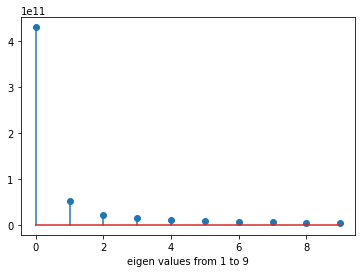

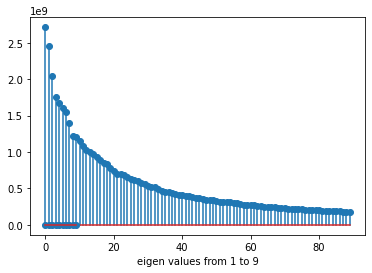

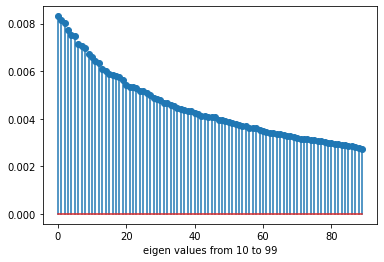

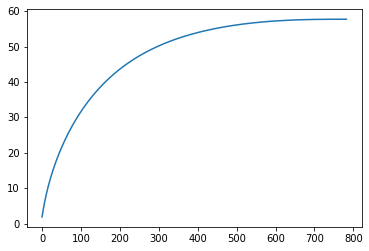

In [19]:
#--------------------------------------------------------------
#-----------------------PREPARATION----------------------------
#--------------------------------------------------------------
x_train,y_train,x_test,y_test = load_dataset()
prepare_dataset(x_train)
prepare_dataset(x_test)



#--------------------------------------------------------------
#-----------------------PROBLEM #1-----------------------------
#--------------------------------------------------------------

print('---------------------PROBLEM #1------------------------------------')
#PROBLEM #1.PART b----------------------------------
n_selected_features_pca = 68

pca_W,pca_top,pca_x_train_trans,pca_x_test_trans = pca_feature_selection(x_train,x_test,n_selected_features_pca)

_,pca_priories,pca_means,pca_covs = compute_stats(pca_x_train_trans,y_train,10)

pca_mecs = max_ent_cov_estimator(pca_covs)

pca_W_i,pca_w_i,pca_w_i0 = disc_params(pca_priories,pca_means,pca_mecs)

pca_acc = evaluation(pca_x_test_trans,y_test,pca_W_i,pca_w_i,pca_w_i0)

print('--------------ACCURACY---------------')
print('\nTHE OVERALL ACCURACY IS:')
print (pca_acc)

print('-----------SQUARE ERROR--------------')
#PCA SQUARE ERROR
pca_err = 0
for i in range(x_train.shape[0]):
  x_tilde = np.matmul(pca_x_train_trans[i,:],pca_top.reshape(n_selected_features_pca,784))
  pca_err += np.linalg.norm((x_tilde - x_train[i,:]))**2

print(pca_err / 60000)

#--------------------------------------------------

#PROBLEM #1.PART a---------------------------------
w_sorted = np.sort(pca_W)
w_sorted = w_sorted[::-1]
w_norm = w_sorted / w_sorted[0]

plt.stem(w_sorted[0:10])
plt.xlabel('eigen values from 1 to 9')
plt.figure()
plt.stem(w_sorted[10:100])
plt.xlabel('eigen values from 10 to 99')
#--------------------------------------------------

print('--------------------------------------------------------------------------\n\n\n')
#--------------------------------------------------------------
#-----------------------PROBLEM #2-----------------------------
#--------------------------------------------------------------

print('---------------------PROBLEM #2------------------------------------')

#2.c-------------------------------------
n_selected_features_fld = 300

fld_W,fld_top,fld_x_train_trans,fld_x_test_trans = fld_feature_selection(x_train,y_train,x_test,10,n_selected_features_fld)

_,fld_priories,fld_means,fld_covs = compute_stats(fld_x_train_trans,y_train,10)

fld_mecs = max_ent_cov_estimator(fld_covs)

fld_W_i,fld_w_i,fld_w_i0 = disc_params(fld_priories,fld_means,fld_mecs)

fld_acc = evaluation(fld_x_test_trans,y_test,fld_W_i,fld_w_i,fld_w_i0)

print('--------------ACCURACY---------------')
print('\nTHE OVERALL ACCURACY IS:')
print (fld_acc)
#-------------------------------------------

#2.a----------------------------------------
fld_w_sorted = np.sort(fld_W)
fld_w_sorted = fld_w_sorted[::-1]
fld_w_norm = fld_w_sorted / fld_w_sorted[0]

plt.stem(fld_w_sorted[0:10])
plt.xlabel('eigen values from 1 to 9')
plt.figure()
plt.stem(fld_w_sorted[10:100])
plt.xlabel('eigen values from 10 to 99')
#--------------------------------------------

#2.b-----------------------------------------
comps = fld_w_norm
for i in range(1,784):
  comps[i] += comps[i-1]

plt.figure()
plt.plot(comps[1:])
#---------------------------------------------


print('\n--------------------------------------------------------------------------')

